In [5]:
import numpy as np
import pandas as pd
# import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import train_test_split
# from osgeo import gdal
from IPython.display import HTML
from base64 import b64encode
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib import colors 

In [6]:
dataset = 'dataSet_Culture_06102023-POINT.json'

classe_info = {
  'not identified':           {'value':0, 'color': '#000000'},
  'soybean':                  {'value':1, 'color': '#ffe32e'},
  'maize':                    {'value':2, 'color': '#FF0000'},
  'cotton':                   {'value':3, 'color': '#0000FF'},
  'coffee':                   {'value':4, 'color': '#75781f'},
  'beans':                    {'value':5, 'color': '#e5eb34'},
  'wheat':                    {'value':6, 'color': '#ff24e5'},
  'sorghum':                  {'value':7, 'color': '#a80a96'},
  'millet':                   {'value':8, 'color': '#fa73eb'},
  'eucalyptus':               {'value':9, 'color': '#c75e0e'},
  'pasture':                  {'value':10, 'color': '#fff68f'},
  'hay':                      {'value':11, 'color': '#c9cf91'},
  'grass':                    {'value':12, 'color': '#12e362'},
  'crotalari':                {'value':13, 'color': '#12e362'},
  'maize+crotalari':          {'value':14, 'color': '#f77159'},
  'cerrado':                  {'value':15, 'color': '#5e2e10'},
  'conversion area':          {'value':16, 'color': '#12e0e3'},
  'uncultivated soil':        {'value':17, 'color': '#a9b0b0'},
  'ncc':                      {'value':18, 'color': '#12e362'},
  'brachiaria':               {'value':19, 'color': '#12e362'},
}

classes = {x : y.get('value') for x, y in classe_info.items()}

classe_colors = [y.get('color') for x, y in classe_info.items()]

features = ['averagevalue']
n_features = len(features)

sequence_size = 30

model_dir = './logs'

In [7]:
df = pd.read_json(dataset)
df.head()

,polygon,indextype,averagevalue,Analysis Date,year contour,elevation_contour,district_name,soil_id,soil_name,culture_name,type_culture_name
0,"{'x': 76.095454293, 'y': 42.728343002}",NDVI,0.217,2020-06-04,2020,1544,Kemin district,28,Горные светло-каштановые,Картофель,Яровая
1,"{'x': 76.095454293, 'y': 42.728343002}",NDVI,0.215,2020-08-03,2020,1544,Kemin district,28,Горные светло-каштановые,Картофель,Яровая
2,"{'x': 76.095454293, 'y': 42.728343002}",NDVI,0.150,2020-09-02,2020,1544,Kemin district,28,Горные светло-каштановые,Картофель,Яровая
3,"{'x': 76.095454293, 'y': 42.728343002}",NDVI,0.052,2021-04-10,2021,1544,Kemin district,28,Горные светло-каштановые,Картофель,Яровая
4,"{'x': 76.095454293, 'y': 42.728343002}",NDVI,0.056,2021-05-05,2021,1544,Kemin district,28,Горные светло-каштановые,Картофель,Яровая


In [8]:
df2 = df.copy()
df2['polygon_x'] = df['polygon'].apply(lambda x: x['x'])
df2['polygon_y'] = df['polygon'].apply(lambda x: x['y'])
df2['month'] = df['Analysis Date'].apply(lambda x: x.split('-')[1])
df2['day'] = df['Analysis Date'].apply(lambda x: x.split('-')[2])
df2['vegetation'] = (df['indextype'] == 'NDVI') & (df['averagevalue'] >= 0.15)
df2 = df2.drop(['polygon', 'soil_id'] , axis = 1)
df2['combined'] = df2['polygon_x'].astype(str) + '_' + df2['polygon_y'].astype(str) + '_' + df2['year contour'].astype(str)
# Assign unique ID based on the grouped column
df2['field_id'] = df2.groupby('combined').ngroup() + 1
# Drop the combined column
df2 = df2.drop(columns=['combined','polygon_x','polygon_y'])

In [9]:
df2 = df2[df2['indextype'] == 'NDVI']

In [10]:
df2 = df2[df2['year contour'] == 2020]

In [11]:
df2 = df2.drop(columns='indextype')

In [12]:
df2 = df2.drop(columns=['district_name', 'soil_name', 'elevation_contour', 'year contour', 'month', 'day', 'vegetation', 'type_culture_name'])

In [13]:
df2

,averagevalue,Analysis Date,culture_name,field_id
0,0.217,2020-06-04,Картофель,986
1,0.215,2020-08-03,Картофель,986
2,0.150,2020-09-02,Картофель,986
99,0.220,2020-06-04,Картофель,989
100,0.177,2020-08-03,Картофель,989
...,...,...,...,...
22912,0.408,2020-05-23,Кукуруза,750
22913,0.206,2020-06-12,Кукуруза,750
22914,0.347,2020-07-07,Кукуруза,750
22915,0.125,2020-08-01,Кукуруза,750


In [14]:
df2 = df2.rename(columns={'field_id': 'id'})

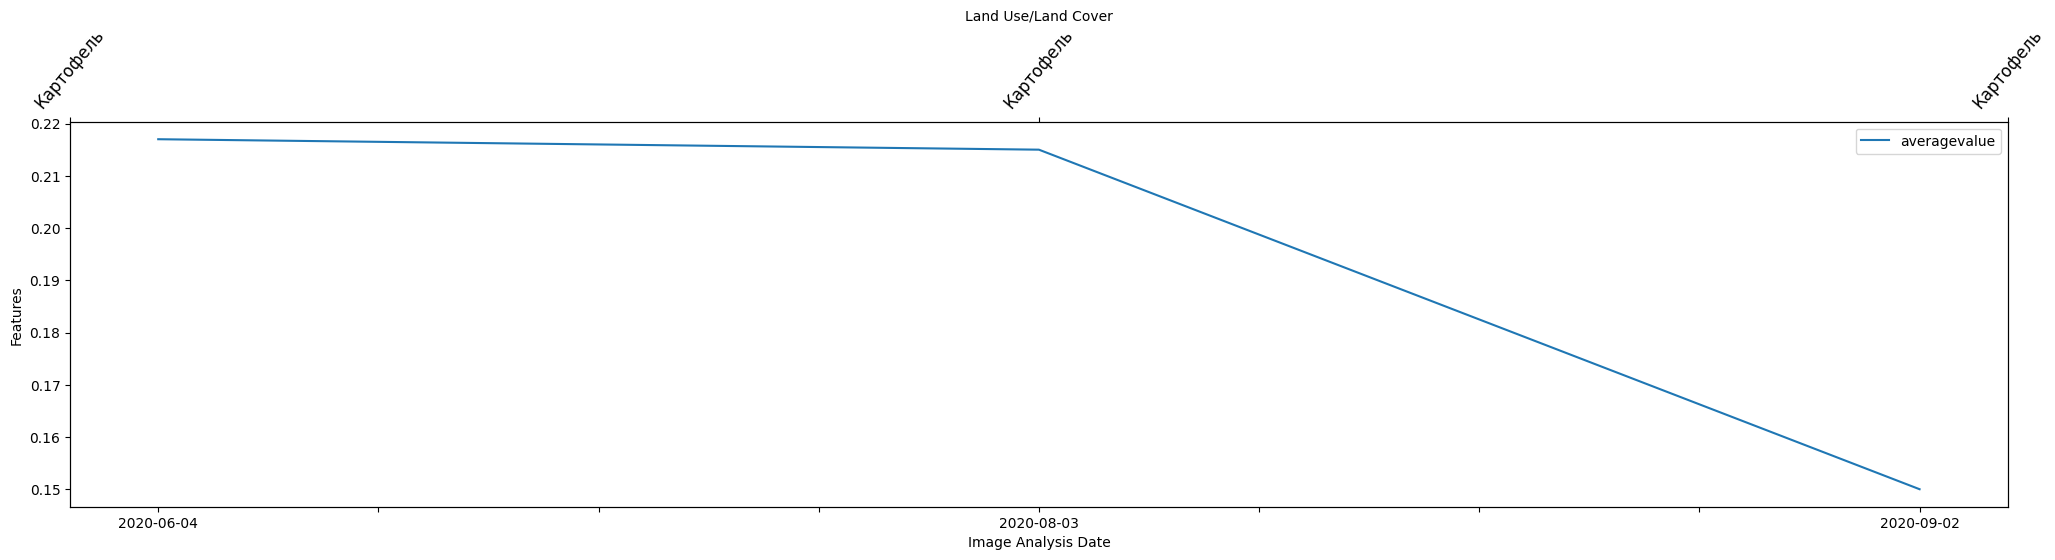

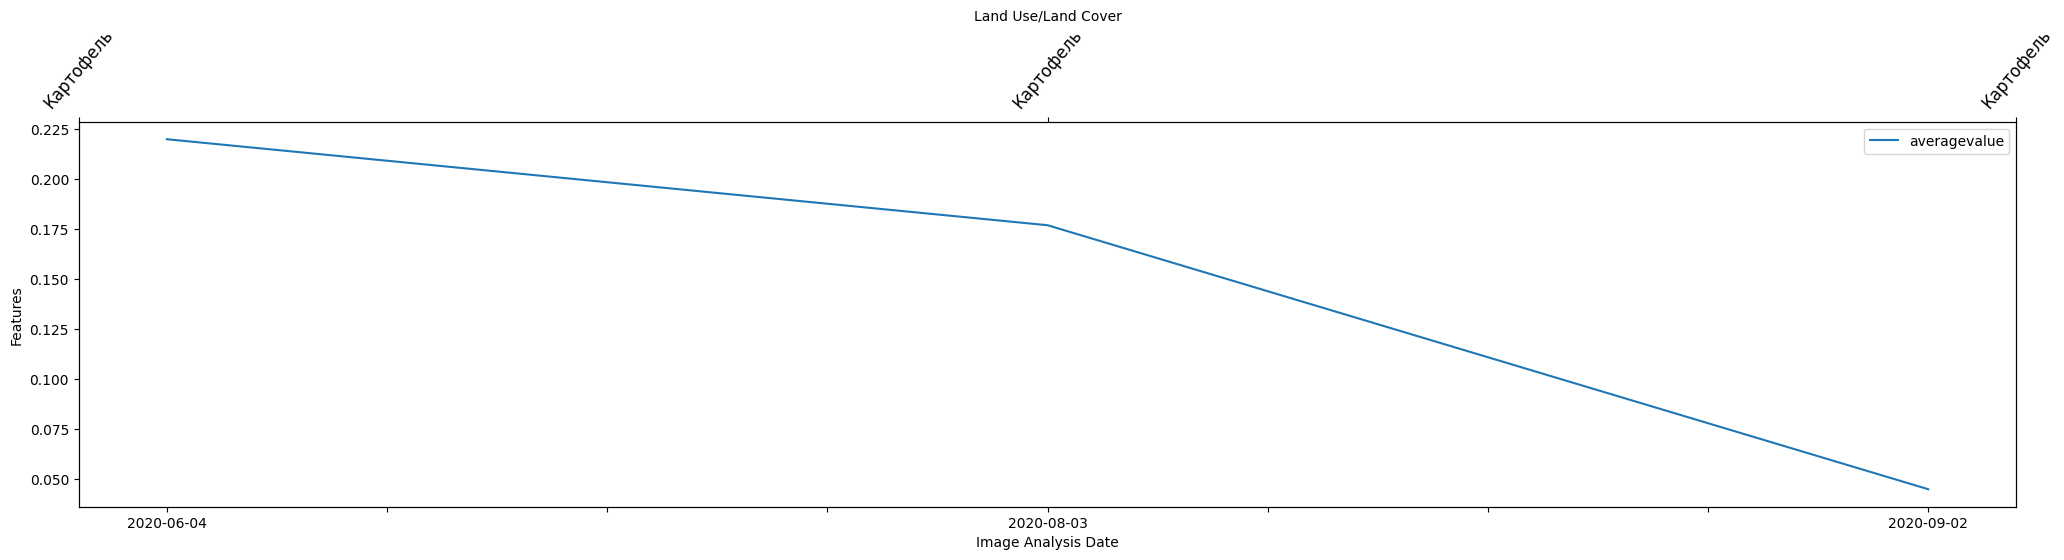

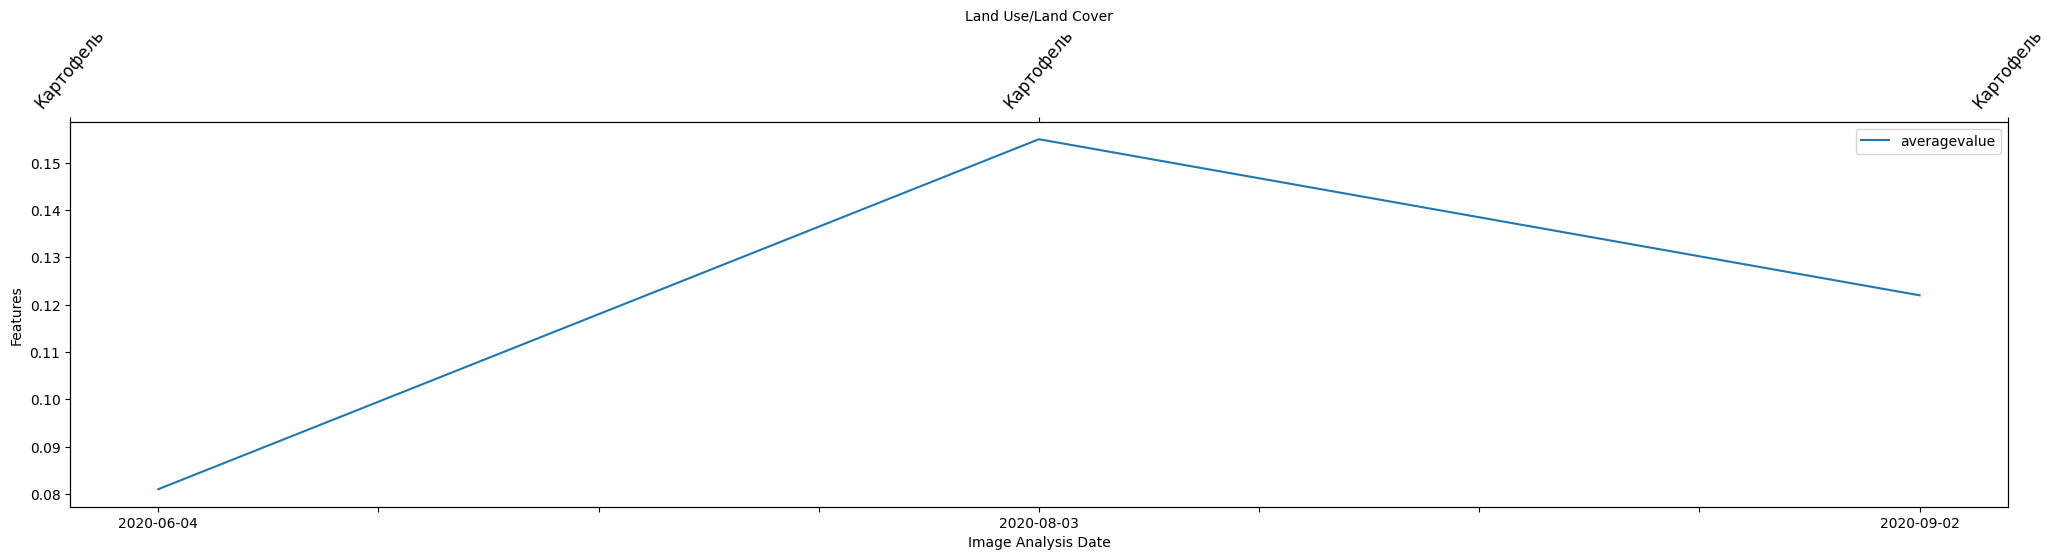

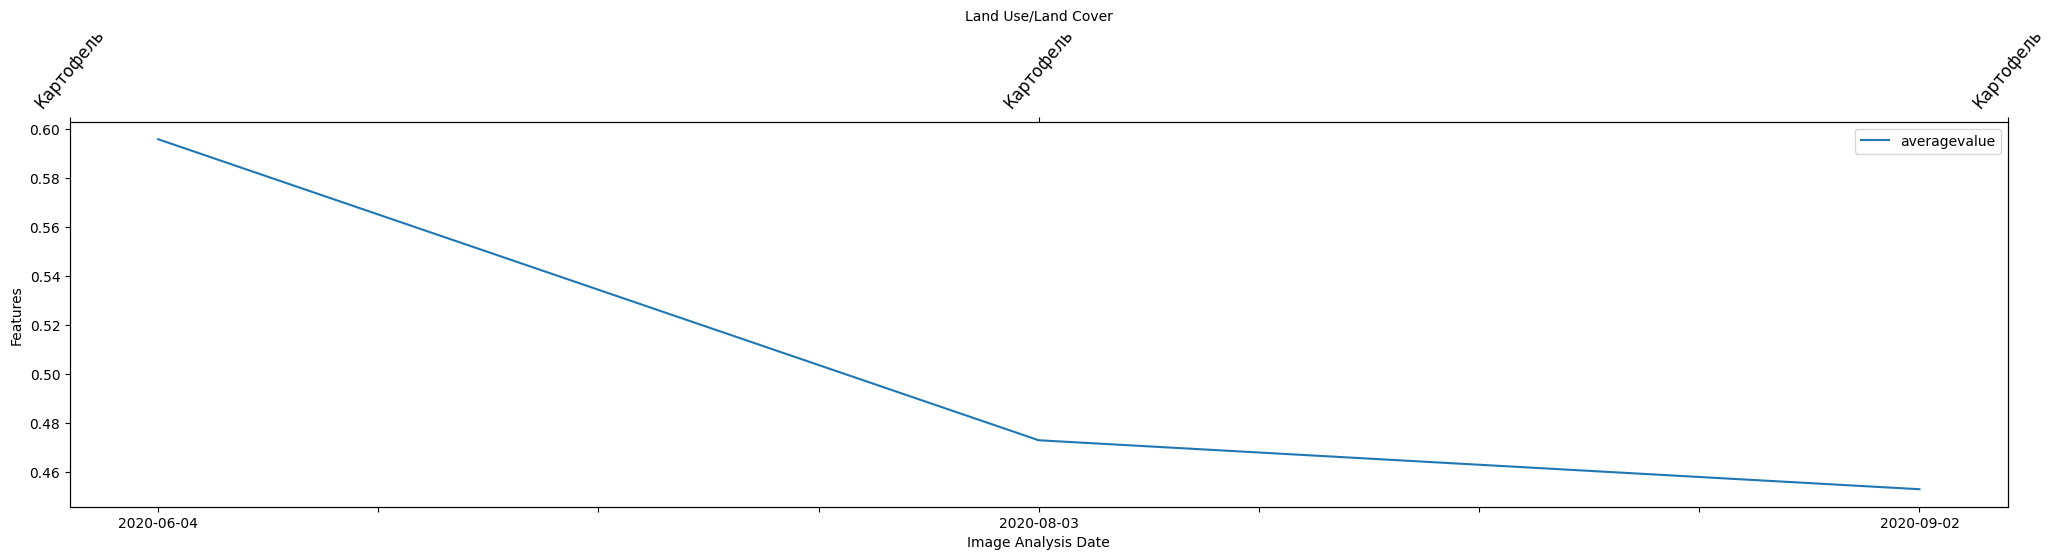

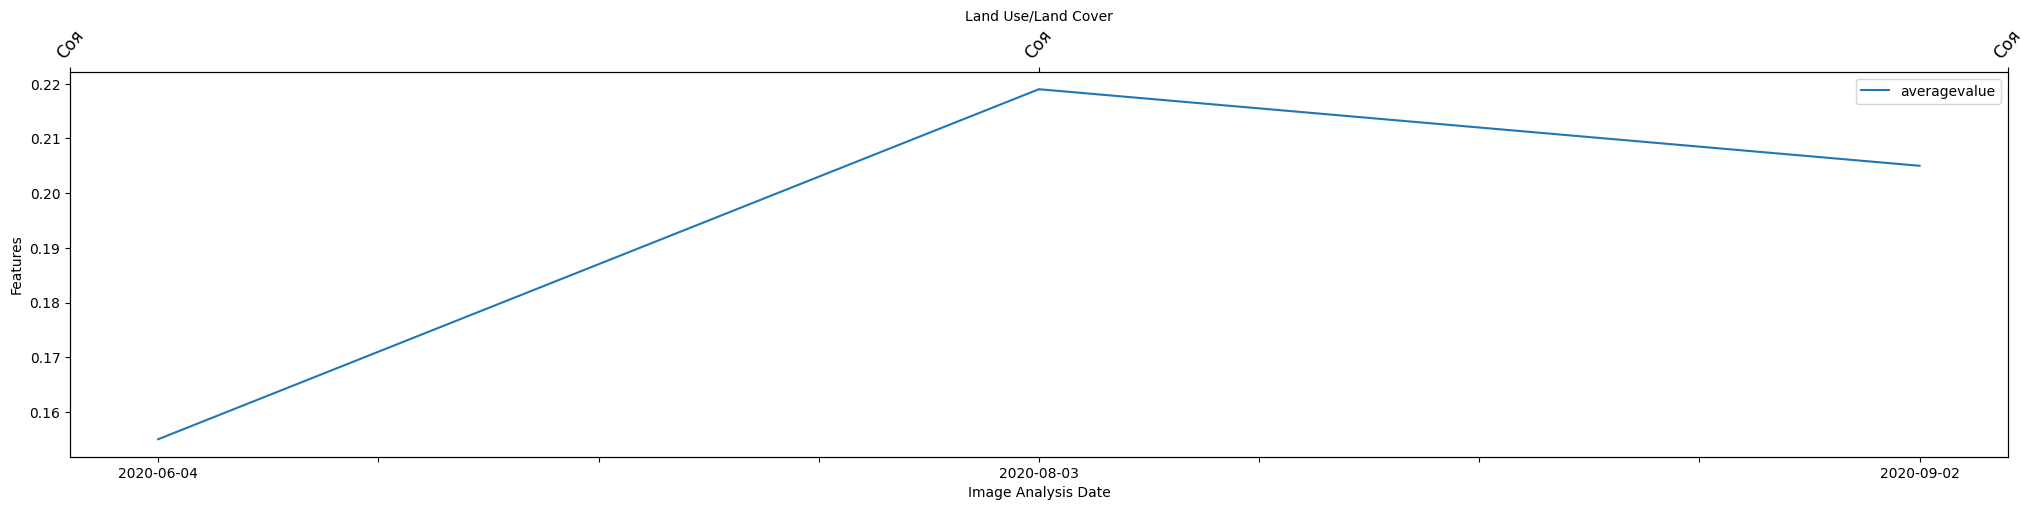

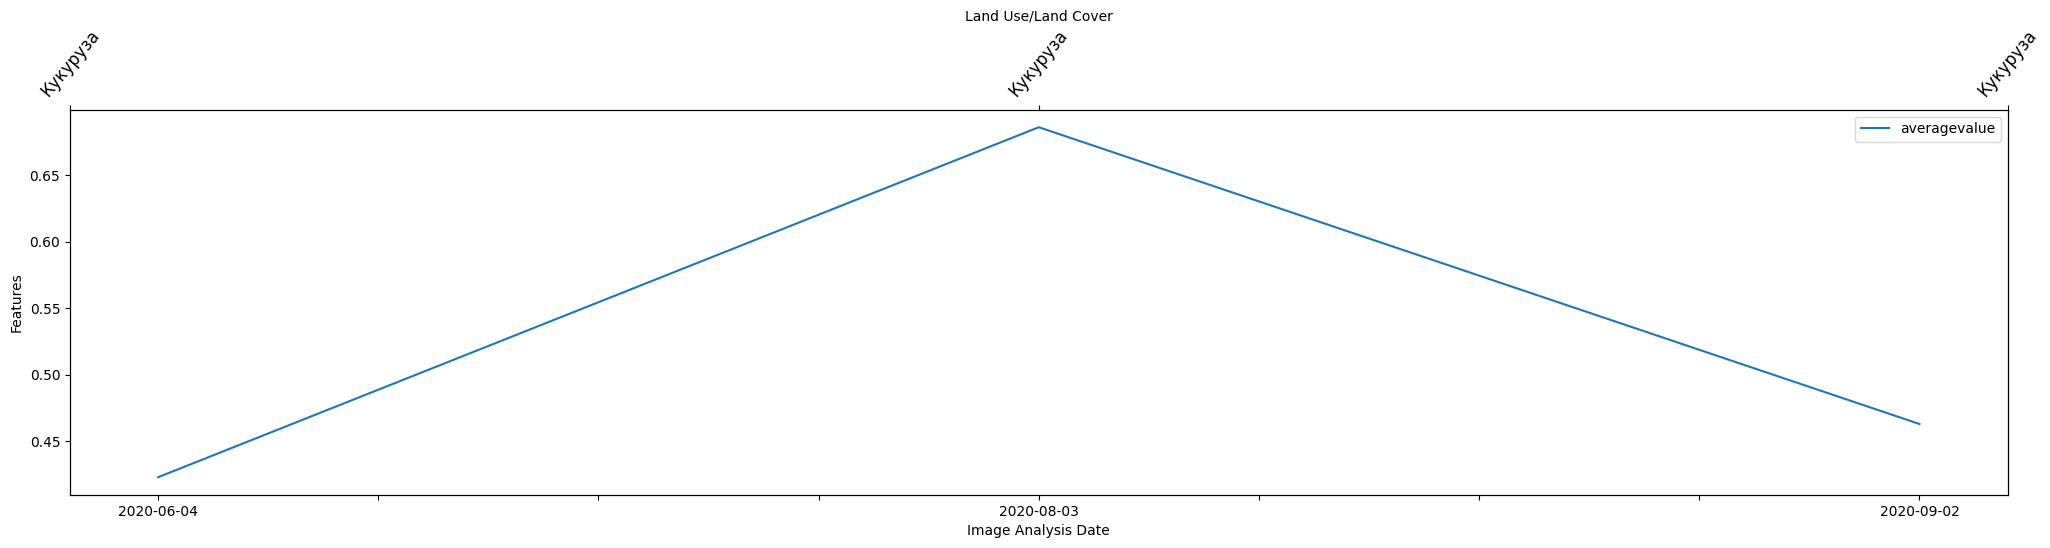

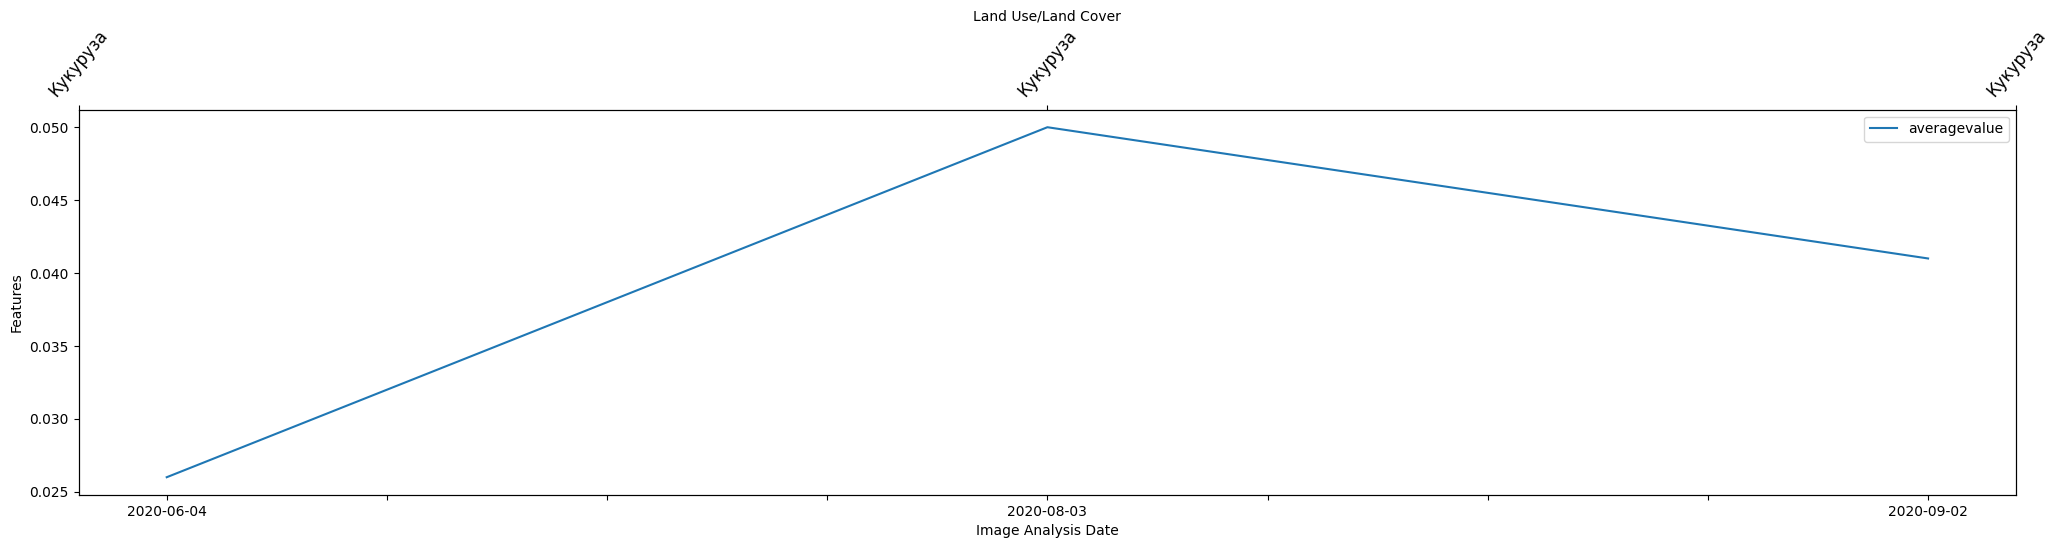

In [15]:
points = df2.id.unique()

for point in points[:7]:
    point_df2 = df2[df2['id'] == point]
    point_df2 = point_df2.sort_values(by=['Analysis Date'])
    ax = point_df2.plot(x='Analysis Date', y=features, figsize=(25, 5))

    axes1 = plt.gca()
    axes2 = axes1.twiny()
    
    culture_names = point_df2['culture_name'].tolist()
    axes2.set_xticks(np.arange(len(culture_names)))
    axes2.set_xticklabels(culture_names, rotation=50, fontsize=12, minor=False)

    axes1.set_ylabel("Features")
    axes1.set_xlabel("Image Analysis Date")
    axes2.set_xlabel("Land Use/Land Cover")

In [17]:
X = []
y = []

for point in points:
    point_df2 = df2[df2['id'] == point]
    point_df2 = point_df2.sort_values(by=['Analysis Date'])

    x_values = point_df2[features].to_numpy()

    # x_values = tf.keras.preprocessing.sequence.pad_sequences([x_values], 
    #                                                          maxlen=sequence_size, dtype='float32')[0]
    # y_values = tf.keras.preprocessing.sequence.pad_sequences([y_values], 
    #                                                          maxlen=sequence_size, 
    #                                                           dtype='float32')[0]
    
    X.append(x_values)
    
    y.append(y_values[1])
    
X = np.array(X)
y = np.array(y)

X = X.reshape((X.shape[0], X.shape[1], n_features))

X.shape, y.shape

NameError: name 'y_values' is not defined

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Sample dataset
# X is your feature matrix, and y is the target variable
# For demonstration purposes, let's assume they're already defined

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
